In [2]:
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/LSTM-Multivariate_pollution.csv') 
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
df.isnull().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [6]:
x_train = df[:24865]
y_train = x_train['pollution']
x_test = df[24865:31898]
y_test = x_test['pollution']
print(y_test)

24865    212.0
24866    206.0
24867    199.0
24868    210.0
24869    194.0
         ...  
31893    123.0
31894    141.0
31895    121.0
31896    110.0
31897    116.0
Name: pollution, Length: 7033, dtype: float64


In [7]:
train_norm = x_train['pollution']

#converted into array as all the methods available are for arrays and not lists
train_norm_arr = np.asarray(train_norm)
train_norm = np.reshape(train_norm_arr, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)
for i in range(5):
    print(train_norm[i])

[0.12977867]
[0.14889336]
[0.15995976]
[0.18209256]
[0.138833]


In [8]:
count = 0
for i in range(len(train_norm)):
    if train_norm[i] == 0:
        count = count +1
print('Number of null values in train_norm = ', count)

Number of null values in train_norm =  1712


In [9]:
train_norm = train_norm[train_norm!=0]

In [10]:
test_norm = x_test['pollution']
test_norm_arr = np.asarray(test_norm)
test_norm = np.reshape(test_norm_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)
for i in range(5):
    print(test_norm[i])

[0.23927765]
[0.23250564]
[0.22460497]
[0.23702032]
[0.21896163]


In [11]:
count = 0
for i in range(len(test_norm)):
    if test_norm[i] == 0:
        count = count + 1 
print('Number of null values in test_norm = ', count)

Number of null values in test_norm =  199


In [12]:
test_norm = test_norm[test_norm != 0]

In [13]:
print(train_norm.shape)
print(test_norm.shape)

(23153,)
(6834,)


In [14]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

In [15]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
#for i in range(len(X_split_train)):
    #print(X_split_train[i], y_split_train[i])
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))

In [16]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))

[0.23927765 0.23250564 0.22460497] 0.237020316027088
[0.23250564 0.22460497 0.23702032] 0.21896162528216703
[0.22460497 0.23702032 0.21896163] 0.22121896162528215
[0.23702032 0.21896163 0.22121896] 0.21896162528216703
[0.21896163 0.22121896 0.21896163] 0.21896162528216703


In [17]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

#sgd = optimizers.SGD(lr=0.001, decay=1e-5, momentum=1.0, nesterov=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True) #good

#keras.optimizers.RMSprop(learning_rate=0.01, rho=0.9)
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [18]:
hist = model.fit(X_split_train, y_split_train, validation_data=(X_split_test, y_split_test), epochs=10, verbose = 1)

Epoch 1/10
724/724 [==============================] - 17s 10ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 1.4639e-04
Epoch 2/10
724/724 [==============================] - 8s 11ms/step - loss: 7.6548e-04 - accuracy: 0.0000e+00 - val_loss: 9.2001e-04 - val_accuracy: 1.4639e-04
Epoch 3/10
724/724 [==============================] - 6s 9ms/step - loss: 6.6355e-04 - accuracy: 0.0000e+00 - val_loss: 8.5112e-04 - val_accuracy: 1.4639e-04
Epoch 4/10
724/724 [==============================] - 8s 11ms/step - loss: 6.4330e-04 - accuracy: 0.0000e+00 - val_loss: 8.0891e-04 - val_accuracy: 1.4639e-04
Epoch 5/10
724/724 [==============================] - 6s 8ms/step - loss: 6.1602e-04 - accuracy: 0.0000e+00 - val_loss: 7.9332e-04 - val_accuracy: 1.4639e-04
Epoch 6/10
724/724 [==============================] - 8s 11ms/step - loss: 6.0839e-04 - accuracy: 0.0000e+00 - val_loss: 8.0760e-04 - val_accuracy: 1.4639e-04
Epoch 7/10
724/724 [==============================] - 6

In [19]:
yhat = model.predict(X_split_test)
for i in range(5):
    print(yhat[i])

214/214 [==============================] - 1s 2ms/step
[0.21298495]
[0.23041344]
[0.20541964]
[0.21273953]
[0.20995404]


In [21]:
pred=[]
for i in yhat:
  pred.append(i[0])
result=pd.DataFrame({'test':y_split_test,'pred':pred})
result


,test,pred
0,0.237020,0.212985
1,0.218962,0.230413
2,0.221219,0.205420
3,0.218962,0.212740
4,0.218962,0.209954
...,...,...
6826,0.138826,0.133105
6827,0.159142,0.139586
6828,0.136569,0.161069
6829,0.124153,0.130729


In [22]:
mse = mean_squared_error(y_split_test, yhat)
from sklearn.metrics import r2_score
print('MSE: %.5f' % mse)
print('R2 Score',r2_score(y_split_test,yhat))

MSE: 0.00086
R2 Score 0.9328330857804575


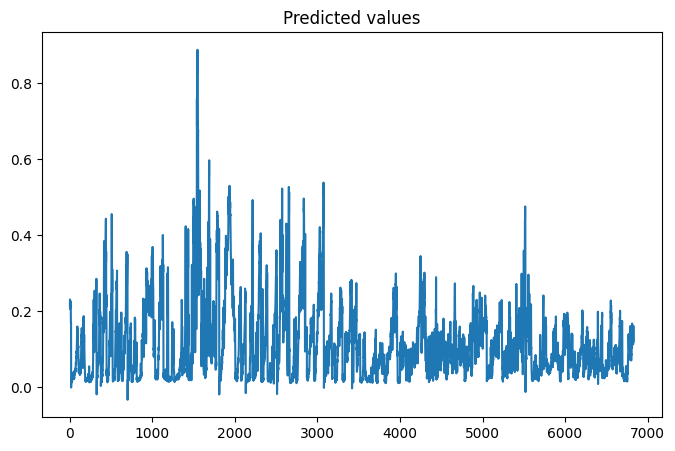

In [23]:
plt.figure(figsize=(8,5))
plt.title('Predicted values')
plt.plot(yhat)


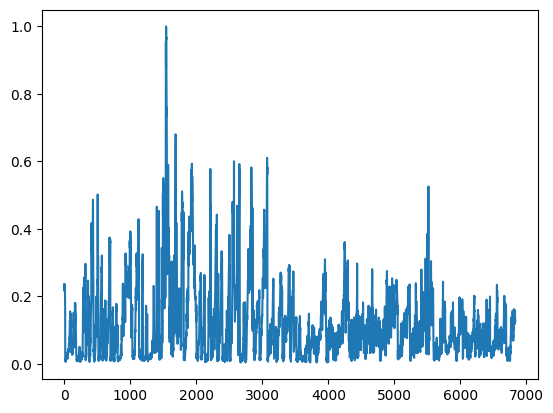

In [24]:
plt.plot(y_split_test)